# CM4 example

In [1]:
# import modules
from IPython import display
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## Load data from esgf node

In [2]:
urlroot = "https://esgdata.gfdl.noaa.gov/thredds/dodsC/gfdl_dataroot4"
subdir = "CMIP/NOAA-GFDL/GFDL-CM4/piControl/r1i1p1f1/Omon"
suffix = "Omon_GFDL-CM4_piControl_r1i1p1f1_gn_025101-027012.nc"

files = [f"{urlroot}/{subdir}/thetao/gn/v20180701/thetao_{suffix}",
         f"{urlroot}/{subdir}/volcello/gn/v20180701/volcello_{suffix}"]

cm4 = xr.open_mfdataset(files, chunks={"time": 1})

In [3]:
cm4

<xarray.Dataset>
Dimensions:    (bnds: 2, time: 240, x: 1440, y: 1080, lev: 35, vertex: 4)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
  * time       (time) object 0251-01-16 12:00:00 ... 0270-12-16 12:00:00
  * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    lon        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lat        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
Dimensions without coordinates: vertex
Data variables:
    lat_bnds   (y, x, vertex) float32 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
    lon_bnds   (y, x, vertex) float32 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
    thetao     (time, lev, y, x) float32 dask.array<chunksize=(1, 35, 1080, 1440), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>
    volcello   (time, lev, y, x) float32 dask.array<chunksize=(1, 35, 1080, 1440), meta=np.ndarray>
Attributes: (12/47)
    title:                           NOAA GFDL GFDL-CM4 model output prepared...
    external_variables:              areacello volcello
    history:                         File was processed by fremetar (GFDL ana...
    table_id:                        Omon
    activity_id:                     CMIP
    branch_method:                   standard
    ...                              ...
    tracking_id:                     hdl:21.14100/07606183-ceb4-4d9a-85d5-270...
    variable_id:                     thetao
    variant_info:                    N/A
    references:                      see further_info_url attribute
    variant_label:                   r1i1p1f1
    DODS_EXTRA.Unlimited_Dimension:  time

In [4]:
# select first record (to save space)
ds = cm4.isel(time=0)

In [5]:
# load data into memory (to save time)
_ = ds.load()

## 1. Plotting

### 1.1 Matplotlib only

The wrong way:

1d **x,y** coords are not the true geographical coordinates, merely an approximation.

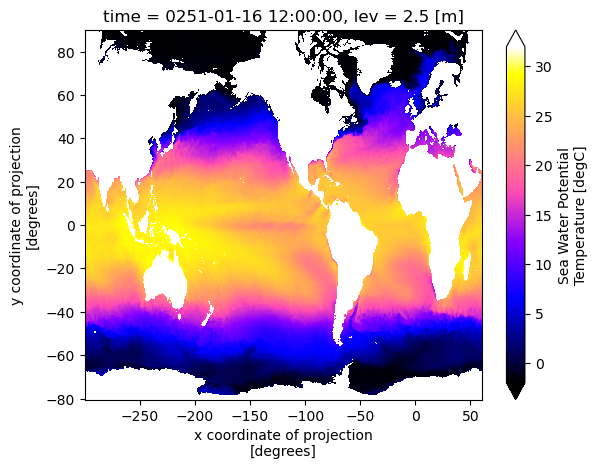

In [6]:
ds["thetao"].sel(lev=2.5).plot(cmap="gnuplot2",
                               vmin=-2, vmax=32)
plt.show()

The right way:

2d **lon/lat** (also named **geolon/geolat**) are the true coordinates, look how much nicer the Arctic looks.

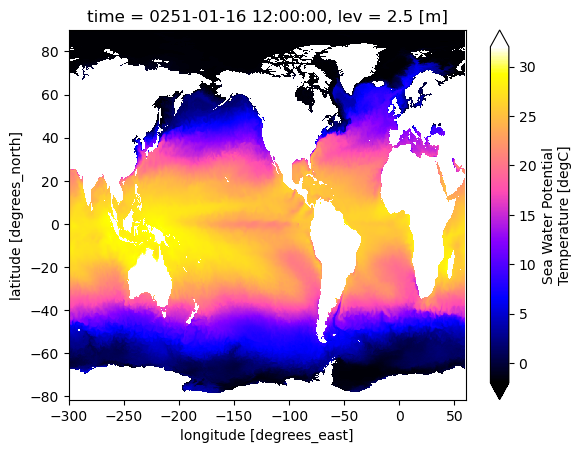

In [7]:
ds["thetao"].sel(lev=2.5).plot(cmap="gnuplot2",
                               x="lon", y="lat",
                               vmin=-2, vmax=32)
plt.show()

### 1.2 Cartopy

In [12]:
from cartopy import crs as ccrs

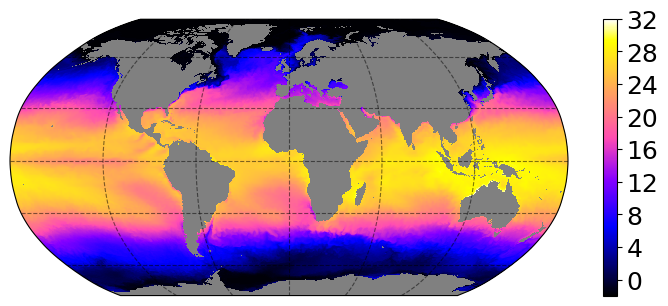

In [13]:
subplot_kws=dict(projection=ccrs.Robinson(),
                 facecolor='grey')
plt.figure(figsize=[9,6])
p = ds["thetao"].sel(lev=2.5).plot(x='lon', y='lat', vmin=-2, vmax=32,
                                   cmap="gnuplot2",subplot_kws=subplot_kws,
                                   transform=ccrs.PlateCarree(),
                                   add_labels=False, add_colorbar=False)
# add separate colorbar
cb = plt.colorbar(p, ticks=[0,4,8,12,16,20,24,28,32], shrink=0.6)
cb.ax.tick_params(labelsize=18)
p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
plt.show()

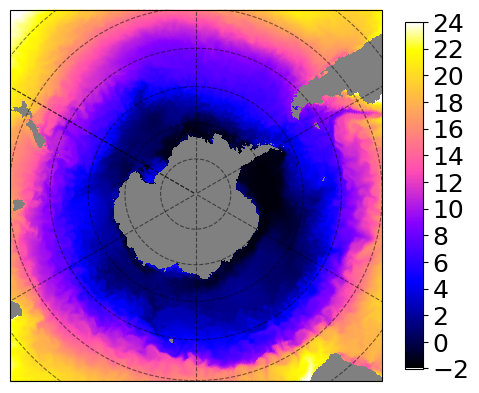

In [14]:
subplot_kws=dict(projection=ccrs.SouthPolarStereo(central_longitude=-120.),
                 facecolor='grey')
plt.figure(figsize=[6,6])
p = ds["thetao"].sel(lev=2.5).plot(x='lon', y='lat',vmin=-2, vmax=24,
                                   cmap="gnuplot2", subplot_kws=subplot_kws,
                                   transform=ccrs.PlateCarree(),
                                   add_labels=False,add_colorbar=False)
# add separate colorbar
cb = plt.colorbar(p, ticks=[-2,0,2,4,6,8,10,12,14,16,18,20,22,24], shrink=0.75)
cb.ax.tick_params(labelsize=18)
p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
p.axes.set_extent([-300, 60, -40, -90], ccrs.PlateCarree())
plt.show()

### Exercise: use the Miller projection, centered on the Pacific to plot temperature at 1000 meters

ref: https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html

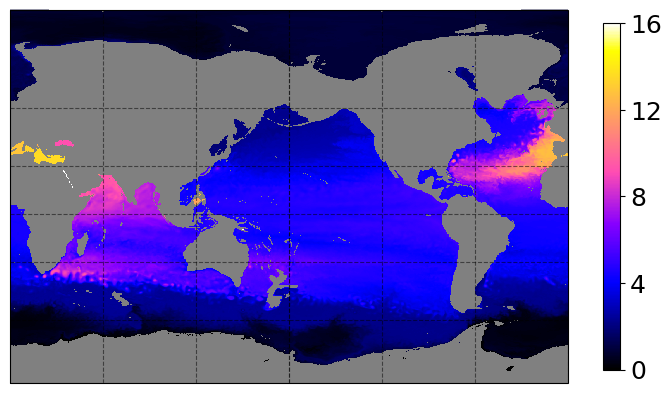

In [15]:
subplot_kws=dict(projection=ccrs.Miller(central_longitude=-180),
                 facecolor='grey')

plt.figure(figsize=[9,6])
p = ds["thetao"].sel(lev=1000.).plot(x='lon', y='lat',vmin=0, vmax=16,
                                     cmap="gnuplot2",subplot_kws=subplot_kws,
                                     transform=ccrs.PlateCarree(),
                                     add_labels=False,add_colorbar=False)
# add separate colorbar
cb = plt.colorbar(p, ticks=[0,4,8,12,16], shrink=0.75)
cb.ax.tick_params(labelsize=18)
p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
plt.show()

## 2. Honey I've shrunk the data

### Data reduction with MOM6

Model adjust the topography (partial step, online edits, channels,...) so the true volume of a cell is given by **volcello** (area = **areacello**, thickness = **thkcello**)

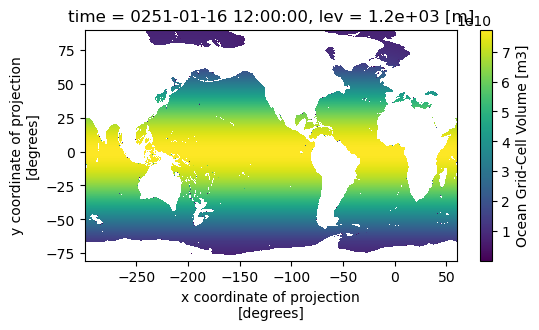

In [16]:
ds["volcello"].isel(lev=20).plot(figsize=[6,3])
plt.show()

### 3D mean ocean temperature

In [17]:
mean_temp_ocean = ((ds["thetao"] *ds["volcello"]).sum(dim=["x", "y", "lev"]) /
                   ds["volcello"].sum(dim=["x", "y", "lev"]))

In [18]:
print(f"mean ocean temperature = {mean_temp_ocean.values:.2f}")

mean ocean temperature = 3.70


### Exercice: compute the mean temperature profile

In [19]:
profile_temp_ocean = ((ds["thetao"] *ds["volcello"]).sum(dim=["x", "y"]) /
                       ds["volcello"].sum(dim=["x", "y"]))

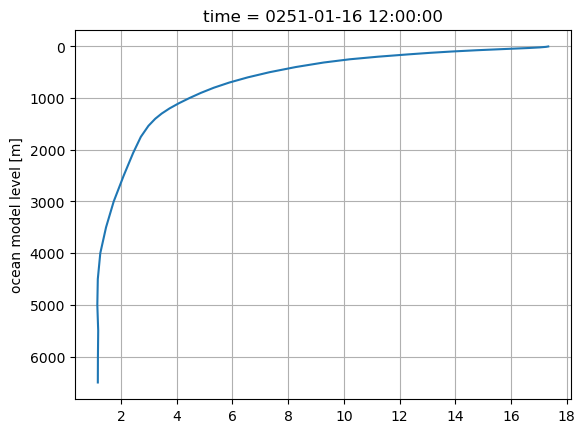

In [20]:
ax = plt.axes()
profile_temp_ocean.plot(ax=ax, y="lev", yincrease=False)
ax.grid()
plt.show()

### Basin average

In [ ]:
#!pip install cmip_basins

In [21]:
from cmip_basins.basins import generate_basin_codes

In [22]:
codes = generate_basin_codes(ds, lon="lon", lat="lat")

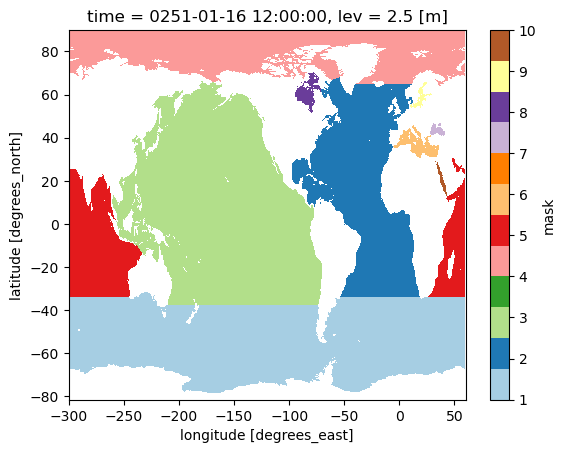

In [23]:
# create a mask
wet = xr.where(ds["volcello"].isel(lev=0).fillna(0.) !=0, 1,0)
codes.where(wet != 0).plot(x="lon", y="lat", cmap="Paired")
plt.show()

In [24]:
# select the Atlantic basin
section_Atl = ds.where(codes == 2).mean(dim="x")
# compute mean latitude (irregular grid)
# and replaces NaNs with min/max value
# remember: coords in xarray do not like NaNs
lat_Atl = ds["lat"].where(codes == 2).mean(dim="x").bfill(dim="y").ffill(dim="y")
# copy back in dataset
section_Atl = section_Atl.assign_coords(lat=lat_Atl)

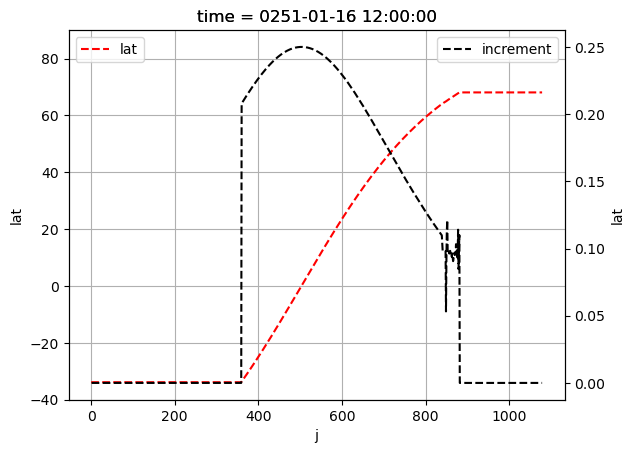

In [26]:
ax1 = plt.axes() ; ax2 = ax1.twinx()
lat_Atl["j"] = xr.DataArray(np.arange(len(lat_Atl)), dims=("y"))
lat_Atl.plot(ax=ax1, x="j", label="lat", ylim=[-40, 90],
             color="r", linestyle="--")
lat_Atl.diff(dim="y").plot(ax=ax2, x="j", label="increment",
                           color="k", linestyle="--")
ax1.grid() ; ax1.legend(loc=2) ; ax2.legend(loc=1) ; plt.show()

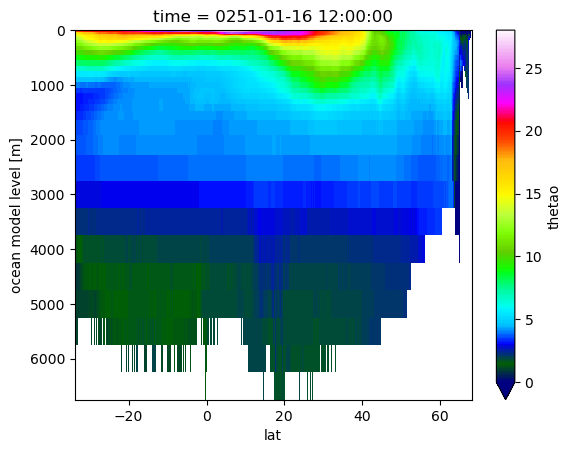

In [27]:
section_Atl["thetao"].plot(x="lat", y="lev", yincrease=False,
                           cmap="gist_ncar", vmin=0, vmax=28)
plt.show()

### Exercice: repeat for Indo-Pacific (hint: 2 basins) 

In [28]:
IPac = xr.where(codes == 3, 1, 0) + xr.where(codes == 5, 1, 0)
section_IPac = ds.where(IPac).mean(dim="x")
lat_IPac = ds["lat"].where(IPac).mean(dim="x").bfill(dim="y").ffill(dim="y")
section_IPac = section_IPac.assign_coords(lat=lat_IPac)

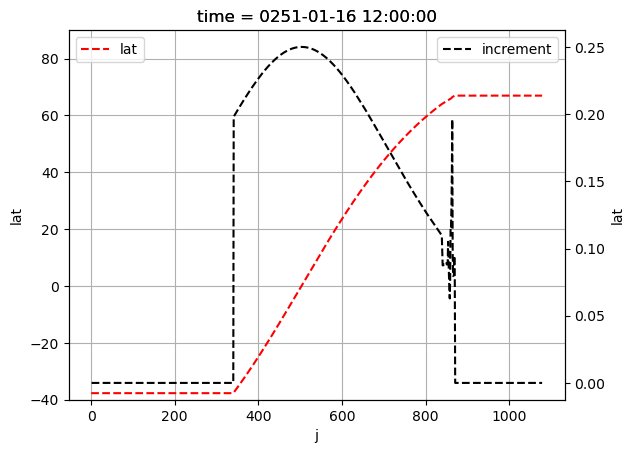

In [29]:
ax1 = plt.axes() ; ax2 = ax1.twinx()
lat_IPac["j"] = xr.DataArray(np.arange(len(lat_IPac)), dims=("y"))
lat_IPac.plot(ax=ax1, x="j", label="lat", ylim=[-40, 90],
             color="r", linestyle="--")
lat_IPac.diff(dim="y").plot(ax=ax2, x="j", label="increment",
                           color="k", linestyle="--")
ax1.grid() ; ax1.legend(loc=2) ; ax2.legend(loc=1) ; plt.show()

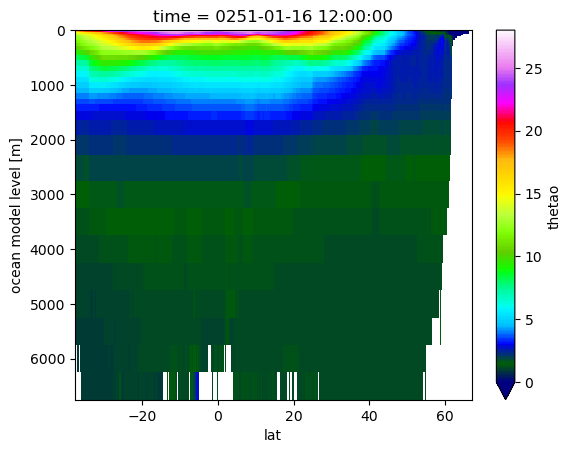

In [30]:
section_IPac["thetao"].plot(x="lat", y="lev", yincrease=False,
                            cmap="gist_ncar", vmin=0, vmax=28)
plt.show()

## 3. Understanding the supergrid

In [ ]:
#!wget -c https://figshare.com/ndownloader/files/37842177 -O ocean_hgrid.nc

In [32]:
hgrid = xr.open_dataset("../ocean_hgrid.nc")

In [33]:
hgrid

<xarray.Dataset>
Dimensions:   (nyp: 2161, nxp: 2881, ny: 2160, nx: 2880)
Dimensions without coordinates: nyp, nxp, ny, nx
Data variables:
    angle_dx  (nyp, nxp) float64 ...
    area      (ny, nx) float64 ...
    dx        (nyp, nx) float64 ...
    dy        (ny, nxp) float64 ...
    tile      |S255 ...
    x         (nyp, nxp) float64 ...
    y         (nyp, nxp) float64 ...

- give lon/lat of all staggered points of C-grid
- also distances between points and angle from E-W
- supergrid is always symmetric

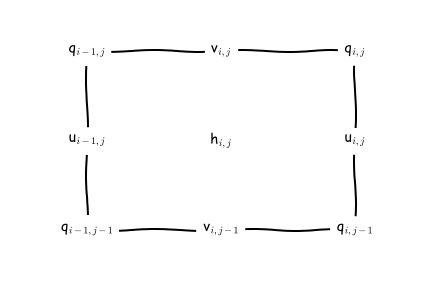

In [34]:
display.Image("https://mom6.readthedocs.io/en/main/_images/Arakawa_C_grid.png")

In [35]:
# cell centers
lon_h = hgrid["x"][1::2,1::2]
lat_h = hgrid["y"][1::2,1::2]

# cell corners
lon_q = hgrid["x"][0::2,0::2]
lat_q = hgrid["y"][0::2,0::2]

In [36]:
# pick just a few points
istart=500
jstart=500

iend_h=istart+3
jend_h=jstart+3

iend_q=istart+4
jend_q=jstart+4

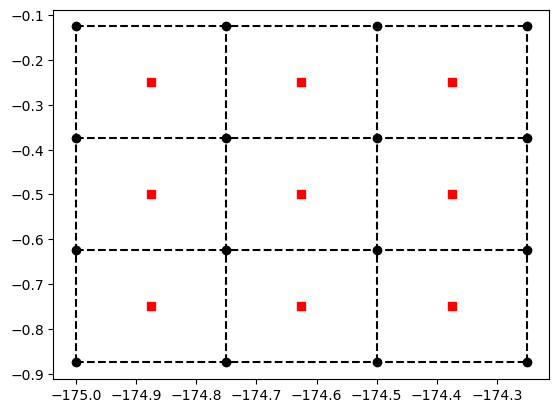

In [37]:
# plot the staggered grid:

plt.figure()
# plot the cell center = tracer point:
plt.plot(lon_h[jstart:jend_h,istart:iend_h],
         lat_h[jstart:jend_h,istart:iend_h], "rs", label="h point")
# plot the cell corner = vorticity point:
plt.plot(lon_q[jstart:jend_q,istart:iend_q],
         lat_q[jstart:jend_q,istart:iend_q], "ko", label="q point")

# trick to plot the grid based on corner points
plt.plot(lon_q[jstart:jend_q,istart:iend_q],
         lat_q[jstart:jend_q,istart:iend_q], "k--")
plt.plot(lon_q[jstart:jend_q,istart:iend_q].transpose(),
         lat_q[jstart:jend_q,istart:iend_q].transpose(), "k--")
plt.show()

### Exercice: add U and V points to the figure

In [38]:
# u points: vertical faces
lon_u = hgrid["x"][1::2,0::2]
lat_u = hgrid["y"][1::2,0::2]

# v points: horizontal faces 
lon_v = hgrid["x"][0::2,1::2]
lat_v = hgrid["y"][0::2,1::2]

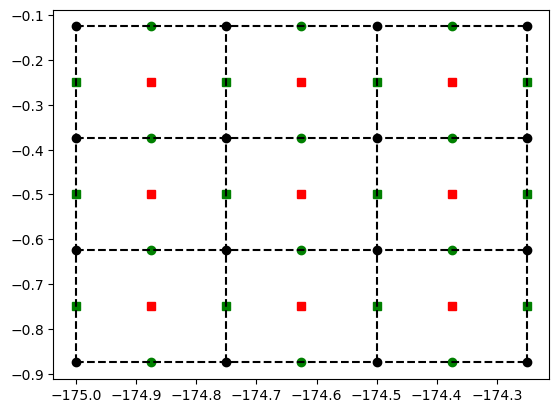

In [39]:
plt.figure()
# plot the cell center = tracer point:
plt.plot(lon_h[jstart:jend_h,istart:iend_h],
         lat_h[jstart:jend_h,istart:iend_h], "rs", label="h point")
# plot the cell corner = vorticity point:
plt.plot(lon_q[jstart:jend_q,istart:iend_q],
         lat_q[jstart:jend_q,istart:iend_q], "ko", label="q point")


# plot the vertical faces = u point:
plt.plot(lon_u[jstart:jend_h,istart:iend_q],
         lat_u[jstart:jend_h,istart:iend_q], "gs", label="u point")
# plot the horizontal faces = v point:
plt.plot(lon_v[jstart:jend_q,istart:iend_h],
         lat_v[jstart:jend_q,istart:iend_h], "go", label="u point")


# trick to plot the grid based on corner points
plt.plot(lon_q[jstart:jend_q,istart:iend_q],
         lat_q[jstart:jend_q,istart:iend_q], "k--")
plt.plot(lon_q[jstart:jend_q,istart:iend_q].transpose(),
         lat_q[jstart:jend_q,istart:iend_q].transpose(), "k--")
plt.show()

## 4. Remapping with xESMF

In [40]:
import xesmf

https://xesmf.readthedocs.io/en/latest/

Create staggered grid from supergrid:

In [41]:
grid_mom = xr.Dataset()

# centers
grid_mom["lon"] = xr.DataArray(lon_h, dims=("ny", "nx"))
grid_mom["lat"] = xr.DataArray(lat_h, dims=("ny", "nx"))
# corners
grid_mom["lon_b"] = xr.DataArray(lon_q, dims=("nyp", "nxp"))
grid_mom["lat_b"] = xr.DataArray(lat_q, dims=("nyp", "nxp"))

Create regular 1 degree grid:

In [42]:
grid_1deg = xr.Dataset()

# centers
grid_1deg["lon"] = xr.DataArray(np.arange(0.5, 360.5, 1),
                                dims=("nx"))
grid_1deg["lat"] = xr.DataArray(np.arange(-89.5, 90.5, 1),
                                dims=("ny"))
# corners
grid_1deg["lon_b"] = xr.DataArray(np.arange(0., 361., 1),
                                dims=("nxp"))
grid_1deg["lat_b"] = xr.DataArray(np.arange(-90., 91., 1),
                                  dims=("nyp"))

### Nearest neighbor

In [43]:
%%time
regrid_nn = xesmf.Regridder(grid_mom, grid_1deg,
                            "nearest_s2d", periodic=True)

CPU times: user 7.46 s, sys: 191 ms, total: 7.65 s
Wall time: 7.64 s


In [44]:
sst_1deg_nn = regrid_nn(ds["thetao"].sel(lev=2.5))

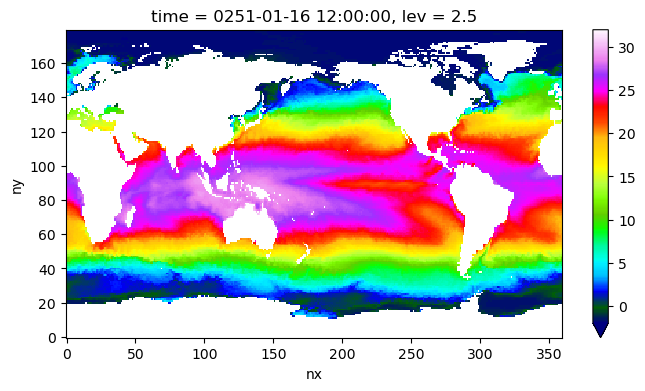

In [45]:
sst_1deg_nn.plot(cmap="gist_ncar", vmin=-2, vmax=32, figsize=[8,4])

### Please try it at home: Bilinear

In [ ]:
%%time
regrid_bilin = xesmf.Regridder(grid_mom, grid_1deg,
                               "bilinear", periodic=True)

In [ ]:
sst_1deg_bilin = regrid_bilin(ds["thetao"].sel(lev=2.5))

In [ ]:
sst_1deg_bilin.plot(cmap="gist_ncar", vmin=-2, vmax=32, figsize=[8,4])

### Please try it at home: Conservative

In [ ]:
%%time
regrid_cons = xesmf.Regridder(grid_mom, grid_1deg,
                              "conservative", periodic=True)

In [ ]:
sst_1deg_cons = regrid_cons(ds["thetao"].sel(lev=2.5))

In [ ]:
#sst_1deg_cons.plot(cmap="gist_ncar", vmin=-2, vmax=32,
#                   figsize=[8,4])
sst_1deg_cons.where(grid_1deg["lat"] > -80.).plot(cmap="gist_ncar",
                                                  vmin=-2, vmax=32,
                                                  figsize=[8,4])

## 5. Developping a fun diagnostics: section following the Gulf Stream north wall

The gulfstream north wall is defined by the 15 degrees isotherm at 200m

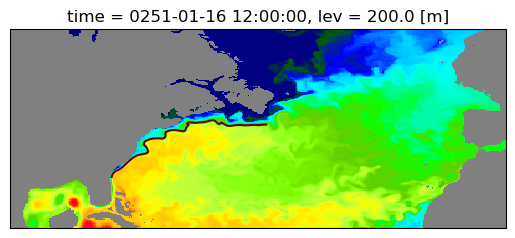

In [46]:
ax = plt.axes(projection=ccrs.Mercator(),
             facecolor="grey")

ds["thetao"].sel(lev=200., x=slice(-100,0), y=slice(20,60)).plot(
                 ax=ax, cmap="gist_ncar",vmin=5,vmax=30,
                 add_colorbar=False)
C = ds["thetao"].sel(lev=200., x=slice(-80,-48),
                     y=slice(30,60)).plot.contour(ax=ax, levels=[15.],
                                                  color="k")

In [48]:
# hack: get points from matplotlib contours
locs = C.allsegs[0][0]
for segment in range(1, len(C.allsegs[0])):
    locs = np.concatenate([locs, C.allsegs[0][segment]], axis=0)

# build a dataset from it
ds_locs = xr.Dataset()
ds_locs['lon'] = xr.DataArray(data=locs[:,0], dims=('stations'))
ds_locs['lat'] = xr.DataArray(data=locs[:,1], dims=('stations'))

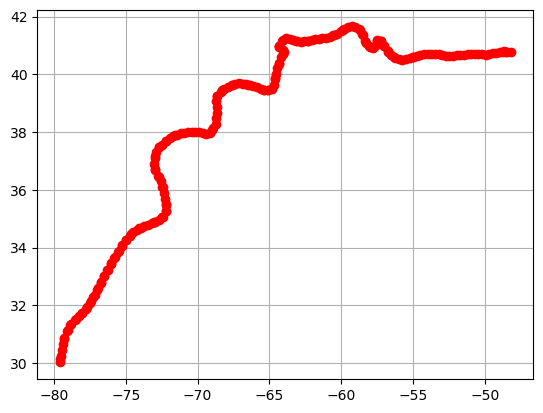

In [49]:
plt.plot(ds_locs["lon"], ds_locs["lat"], "ro")
plt.grid()

In [50]:
regrid_northwall = xesmf.Regridder(grid_mom, ds_locs, "bilinear",
                                   locstream_out=True)

In [51]:
temp_northwall = regrid_northwall(ds["thetao"])

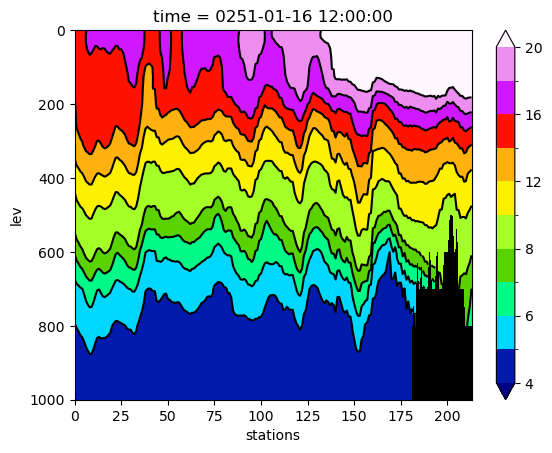

In [52]:
ax=plt.axes(facecolor="k")
levels = [4,5,6,7,8,10,12,14,16,18,20]
temp_northwall.plot.contourf(ax=ax, x="stations", y="lev", levels=levels,
                             cmap="gist_ncar", ylim=[1000,0], yincrease=False)
temp_northwall.plot.contour(ax=ax, x="stations", y="lev", levels=levels,
                            colors="k", ylim=[1000,0], yincrease=False)

In [53]:
temp_northwall["lon"] = ds_locs["lon"]
temp_northwall["lat"] = ds_locs["lat"]

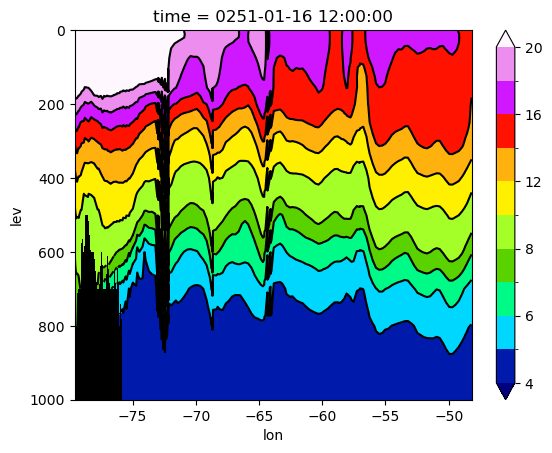

In [54]:
temp_northwall_sorted = temp_northwall.sortby("lon")

ax=plt.axes(facecolor="k")
levels = [4,5,6,7,8,10,12,14,16,18,20]
temp_northwall_sorted.plot.contourf(ax=ax, x="lon", y="lev", levels=levels,
                                    cmap="gist_ncar", ylim=[1000,0], yincrease=False)
temp_northwall_sorted.plot.contour(ax=ax, x="lon", y="lev", levels=levels, colors="k",
                                   ylim=[1000,0], yincrease=False)

### Exercice: plot against lattitude

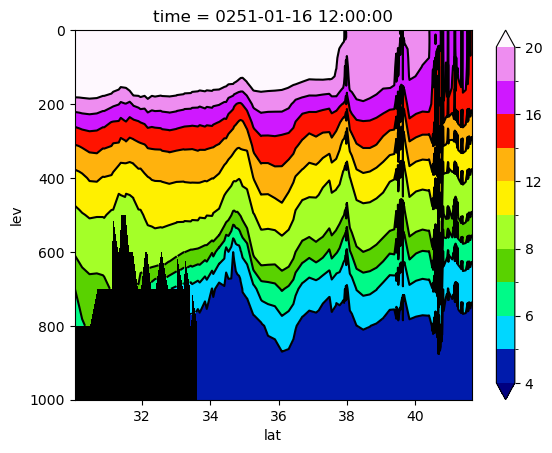

In [55]:
temp_northwall_sorted = temp_northwall.sortby("lat")

ax=plt.axes(facecolor="k")
temp_northwall_sorted.plot.contourf(ax=ax, x="lat", y="lev", levels=levels,
                                    cmap="gist_ncar", ylim=[1000,0], yincrease=False)
temp_northwall_sorted.plot.contour(ax=ax, x="lat", y="lev", levels=levels,
                                   colors="k", ylim=[1000,0], yincrease=False)

## 6. Fixing missing processors in output

In [56]:
# get land sea mask
mask = xr.where(ds["thetao"].sel(lev=2.5).fillna(9999.) == 9999., 0, 1)

# assuming layout of 20x20 gridpoints per processor = 54x72 
# domain decomposition
ocean_fraction = mask.coarsen(y=54, x=72).mean()

# upscale ocean fraction
tmp = np.repeat(ocean_fraction.values, 72, axis=-1)
tmp2 = np.repeat(tmp, 54, axis=0)
ocean_fraction_fullres = xr.DataArray(tmp2, dims=("y", "x"))

# land processor elimination
ds_gruyere = ds.copy()
ds_gruyere["lon"] = ds["lon"].where(ocean_fraction_fullres != 0)
ds_gruyere["lat"] = ds["lat"].where(ocean_fraction_fullres != 0)

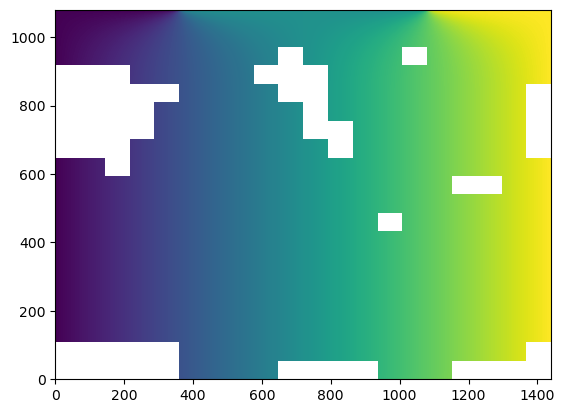

In [57]:
plt.pcolormesh(ds_gruyere["lon"])

ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.core.MaskedArray with masked values

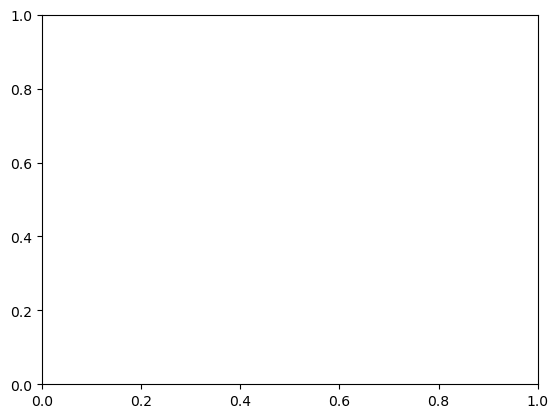

In [58]:
ds_gruyere["thetao"].sel(lev=2.5).plot(x="lon", y="lat")

**how do we fix that ?**

In [59]:
def fix_holes(da, dim, cutoff):

    return xr.concat([da.isel({dim: slice(0,cutoff)}).bfill(dim),
                      da.isel({dim: slice(cutoff, None)}).ffill(dim)],
                     dim=dim)

In [60]:
# use southern ocean as cutoff
geolon_fixed = fix_holes(ds_gruyere["lon"], "y", 200)

# use Bering strait
geolat_fixed = fix_holes(ds_gruyere["lat"], "x", 500)

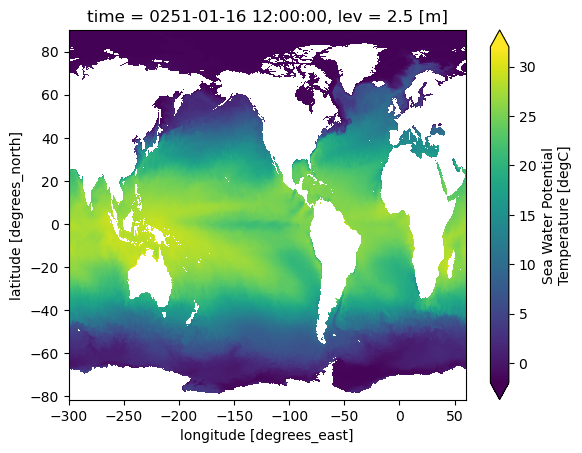

In [61]:
ds_gruyere["lon"] = geolon_fixed
ds_gruyere["lat"] = geolat_fixed

ds_gruyere["thetao"].sel(lev=2.5).plot(x="lon", y="lat",
                                       vmin=-2, vmax=32)

### Final words

There are many other xarray-based tools we have developped, look at github repos from Alistair Adcroft, John Krasing,... and myself ;)

Also check out the cookbook and contribute:
    
https://mom6-analysiscookbook.readthedocs.io/en/latest/index.html